In [ ]:
!pip install gdown -q
print("Downloading folder from Drive...")
# Downloads the folder structure containing the Linemod dataset
!gdown "https://drive.google.com/file/d/1Zwh-gAk_-CBgpOcNLPLdFNxggi3NTh-S/view?usp=drive_link" --fuzzy
import glob
zip_files = glob.glob("**/Linemod_preprocessed.zip", recursive=True)

if zip_files:
    zip_path = zip_files[0]
    print(f"Unzipping {zip_path}...")
    !unzip -q -o "{zip_path}"
    print("Extraction complete!")
else:
    print("Error: Linemod_preprocessed.zip not found. Check the download.")

Cloning into '6D_pose'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 174 (delta 87), reused 113 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (174/174), 2.23 MiB | 6.95 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Cloned https://github.com/fraco03/6D_pose.git to /content/6D_pose


In [1]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "main"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git pull origin {branch}
    # !git fetch origin
    # !git checkout {branch}
    # !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

Cloning into '6D_pose'...
remote: Enumerating objects: 798, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 798 (delta 55), reused 77 (delta 32), pack-reused 674 (from 1)
Receiving objects: 100% (798/798), 11.42 MiB | 27.14 MiB/s, done.
Resolving deltas: 100% (437/437), done.
Cloned https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [3]:
# Cancella tutte le cartelle __pycache__ ricorsivamente nella directory di lavoro
!find . -name "__pycache__" -type d -exec rm -rf {} +
print("🗑️ Cache pulita dal disco.")

🗑️ Cache pulita dal disco.


In [5]:
%rm 6D_pose/src/pose_rgb/__init__.py

In [5]:
!pip install plyfile
from src.pose_rgb.dataset import LineModPoseDataset
from src.pose_rgb.model import ResNetRotation, TranslationNet
from src.pose_rgb.pose_utils import quaternion_to_rotation_matrix, convert_rotation_to_quaternion, inverse_pinhole_projection
from src.pose_rgb.loss import CombinedPoseLoss, MultiObjectPointMatchingLoss, TranslationLoss
from torch.utils.data import Dataset, DataLoader
import pathlib
import torch.optim as optim
from tqdm import tqdm
from utils.projection_utils import *
from utils.linemod_config import *
from metrics import compute_ADD_metric_quaternion


In [6]:
root_dir = '/kaggle/input/line-mode/Linemod_preprocessed' #Modify here for kaggle
# root_dir = "../../Linemod_preprocessed_small"  # Adjust path as needed
dayaset_root = root_dir
device = ('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = LineModPoseDataset(split='train', root_dir=root_dir)
test_dataset = LineModPoseDataset(split='test', root_dir=root_dir)

#Dataloder
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

✅ LineModConfig initialized: /kaggle/input/line-mode/Linemod_preprocessed
 Loaded LineModPoseDataset
   Split: train (Ratio: 0.80)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 12610
 Loaded LineModPoseDataset
   Split: test (Ratio: 0.20)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3163


In [23]:
import torch
import numpy as np
import os

def load_all_object_points(num_points=1000):
    """
    Loads .ply files for ALL objects and stacks them into a single Tensor.
    
    Args:
        models_dir (str): Folder containing .ply files (e.g., 'obj_01.ply').
        valid_obj_ids (list): List of integers IDs (e.g., [1, 5, 6...]).
        num_points (int): Number of points to sample per object.
        
    Returns:
        torch.Tensor: Shape (Num_Classes, num_points, 3).
                      The index in dimension 0 corresponds to the index in valid_obj_ids.
    """
    global dataset_root
    linemod_config = get_linemod_config(dataset_root)

    all_model_points = []
    VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
    for obj_id in VALID_OBJ_IDS:
        model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
        if model_points.shape[0] >= num_points:
            choice = np.random.choice(model_points.shape[0], num_points, replace=False)
        else:
            choice = np.random.choice(model_points.shape[0], num_points, replace=True)
        model_points = model_points[choice, :]
        all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
    all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
    all_model_points = all_model_points.to(device)
    return all_model_points

VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
max_obj_id = max(VALID_OBJ_IDS)

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx
        
    

# ROTATION ONLY

In [ ]:
# ONLY ROTATION TRAINING SCRIPT
import os
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime
from itertools import islice
import numpy as np

# ==========================================
# 1. SETUP & HYPERPARAMETERS
# ==========================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

# --- PATHS ---
# Define where your .ply models are located
MODELS_DIR = '/kaggle/input/line-mode/Linemod_preprocessed/models' 
# List of valid object IDs in your dataset (must match your dataset logic)
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 

# --- LOGGING SETUP ---
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Directory to save checkpoints and logs
CHECKPOINT_DIR = f'/kaggle/working/run_rotation' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
run_dir = CHECKPOINT_DIR

print(f"\n🔥 STARTING ROTATION-ONLY TRAINING on {DEVICE}...")
print(f"📁 Saving outputs to: {run_dir}")

# ==========================================
# 2. INITIALIZE LOSS & MODELS
# ==========================================

# A. LOAD 3D POINTS FOR LOSS
# We need to load the point clouds for all objects to use PointMatchingLoss.
print("📦 Loading 3D Point Clouds for Loss Function...")
# Use the helper function we defined earlier to load all ply files
point_bank = load_all_object_points(MODELS_DIR, VALID_OBJ_IDS, num_points=1000)
point_bank = point_bank.to(DEVICE) # Move entire bank to GPU


# B. DEFINE LOSS FUNCTION

criterion = MultiObjectPointMatchingLoss(point_bank).to(DEVICE)

# C. INITIALIZE MODEL
# We only use the Rotation Network
model_rot = ResNetRotation(freeze_backbone=False).to(DEVICE)

# D. OPTIMIZER
# We only optimize the rotation model parameters
optimizer = optim.Adam(
    model_rot.parameters(),
    lr=LEARNING_RATE
)

# E. METRICS STORAGE
train_losses = []
val_losses = []
best_val_loss = float('inf')

# ==========================================
# 3. TRAINING LOOP
# ==========================================
for epoch in range(NUM_EPOCHS):

    # --- A. TRAIN PHASE ---
    model_rot.train()
    running_train_loss = 0.0

    # Progress Bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for batch in pbar:
        # 1. Move data to GPU
        imgs = batch['image'].to(DEVICE)
        gt_rot = batch['rotation'].to(DEVICE)
        
        # We need class indices for the PointMatchingLoss (Index 0 to 12)
        # Ensure your Dataset returns 'class_id' as a mapped index (0..N), NOT the raw Linemod ID (1,5,8..)
        obj_ids = batch['object_id'].to(DEVICE)
        class_ids = obj_id_to_idx[obj_ids]
        
        # 2. Forward Pass
        pred_rot = model_rot(imgs)

        # 3. Calculate Loss
        # Pass class_ids so the loss knows which 3D model to use for each image in the batch
        if point_bank is not None:
            loss = criterion(pred_rot, gt_rot, class_ids)
        else:
            loss = criterion(pred_rot, gt_rot) # Fallback doesn't use IDs

        # 4. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 5. Logging
        running_train_loss += loss.item()
        pbar.set_postfix({'ADD Loss': f"{loss.item():.4f}"})

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- B. EVALUATION PHASE ---
    model_rot.eval()
    running_val_loss = 0.0
    val_batches_limit = 50  # Validate on a subset to save time per epoch
    count_batches = 0

    with torch.no_grad():
        val_iterator = islice(test_loader, val_batches_limit)
        val_pbar = tqdm(val_iterator, total=val_batches_limit, desc="Validating")

        for batch in val_pbar:
            imgs = batch['image'].to(DEVICE)
            gt_rot = batch['rotation'].to(DEVICE)
            # raw_names_list = batch['class_idx'] # es. ['can', 'ape', 'driller']
            obj_ids = batch['object_id'].to(DEVICE)
            class_ids = obj_id_to_idx[obj_ids]
            

            # Forward
            pred_rot = model_rot(imgs)

            # Loss
            if point_bank is not None:
                loss = criterion(pred_rot, gt_rot, class_ids)
            else:
                loss = criterion(pred_rot, gt_rot)
                
            running_val_loss += loss.item()
            count_batches += 1

    avg_val_loss = running_val_loss / count_batches if count_batches > 0 else 0
    val_losses.append(avg_val_loss)

    # --- C. REPORT & SAVE ---
    print(f"📊 Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_path = os.path.join(CHECKPOINT_DIR, "best_model_rot.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_rot.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss
        }, save_path)
        print(f"🏆 New Best Rotation Model Saved! (Loss: {best_val_loss:.4f})")

    # Save Last Checkpoint (for resuming if needed)
    if (epoch + 1) == NUM_EPOCHS:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_rot.state_dict(),
            'val_loss': avg_val_loss
        }, os.path.join(CHECKPOINT_DIR, f"checkpoint_last.pth"))

# --- D. PLOTTING ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (ADD Metric)')
plt.plot(val_losses, label='Val Loss (ADD Metric)')
plt.title('Rotation Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Average Distance (m)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(CHECKPOINT_DIR, 'rotation_training_curve.png'))
print("🎉 TRAINING COMPLETE! Training curve saved.")

# Translation ONLY

In [13]:
# ONLY TRANSLATION TRAINING SCRIPT
from src.pose_rgb import model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os
import numpy as np
from src.pose_rgb.pose_utils import inverse_pinhole_projection

# ==========================================
# 1. CONFIGURATION
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64        # Adjust if you run out of memory
LR = 0.001             # Constant Learning Rate
NUM_EPOCHS = 30
CHECKPOINT_DIR = f'/kaggle/working/run_translation' 
DATA_ROOT = '/kaggle/input/line-mode/Linemod_preprocessed'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ==========================================
# 2. MODEL & OPTIMIZER SETUP
# ==========================================
print(f"🧠 Initializing Model on {DEVICE}...")

# Initialize your custom TranslationNet
model_transl = TranslationNet()

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPU!")
    model_transl = nn.DataParallel(model_transl)
model_transl = model_transl.to(DEVICE)

# Define Loss (Weighted to prioritize Depth Z)
criterion = TranslationLoss(z_weight=4.5) 

# Scheduler and optimizer
LR_MAX = 1e-3
WEIGHT_DECAY = 1e-2
EPOCHS = 30
STEPS_PER_EPOCH = len(train_loader)

optimizer = optim.AdamW(
    model_transl.parameters(), 
    lr=LR_MAX / 10,  # OneCycleLR handles the lr
    weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR_MAX,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    pct_start=0.3,  # Il 30% del tempo speso a far salire il LR
    anneal_strategy='cos'
)

# ==========================================
# 3. TRAINING LOOP
# ==========================================
best_val_mae = float('inf') # Track the best error to save the best model

print("🚀 Starting Training Loop...")

for epoch in range(NUM_EPOCHS):
    
    # --- TRAIN PHASE ---
    model_transl.train()
    running_loss = 0.0
    
    # Progress bar for training
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for batch in train_loop:
        # Move data to GPU
        imgs = batch['image'].to(DEVICE)           # (B, 3, 224, 224)
        bbox_info = batch['bbox_info'].to(DEVICE)  # (B, 4) Normalized BBox GPS
        gt_trans = batch['translation'].to(DEVICE) # (B, 3) Absolute Translation in METERS

        bbox_center = batch['bbox_center'].to(DEVICE) # (B, 2) [cx_pix, cy_pix]
        cam_K = batch['cam_K'].to(DEVICE)             # (B, 3, 3)

        original_width = batch['original_width'].to(DEVICE)
        original_height = batch['original_height'].to(DEVICE)

        # Forward Pass
        preds_raw = model_transl(imgs, bbox_info)

        # Interpretiamo l'output non come pixel, ma come fattori relativi
        pred_relative_deltas = preds_raw[:, :2] 
        
        # Recuperiamo le dimensioni reali della BBox (pixel originali)
        W_real = bbox_info[:, 2] * original_width
        H_real = bbox_info[:, 3] * original_height

        real_dims = torch.stack([W_real, H_real], dim=1) # (Batch, 2)

        pred_deltas = pred_relative_deltas * real_dims
    
        
        pred_log_z = preds_raw[:, 2]   # (B, )  -> log(z)

        pred_z = torch.exp(pred_log_z).clamp(min=0.1, max=10.0)

        preds_abs = inverse_pinhole_projection(
            crop_center=bbox_center,
            deltas=pred_deltas,
            z=pred_z,
            cam_K=cam_K
        )
        
        # Calculate Loss
        loss = criterion(preds_abs, gt_trans)
        
        # Backward Pass (Update Weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Update stats
        running_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

    # --- VALIDATION PHASE ---
    model_transl.eval()
    val_loss = 0.0
    
    # Variables to calculate error in Centimeters (for human readability)
    error_sum_xyz = np.array([0.0, 0.0, 0.0]) 
    total_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Eval]"):
            imgs = batch['image'].to(DEVICE)
            bbox_info = batch['bbox_info'].to(DEVICE)
            gt_trans = batch['translation'].to(DEVICE)
            bbox_center = batch['bbox_center'].to(DEVICE)
            cam_K = batch['cam_K'].to(DEVICE)

            original_width = batch['original_width'].to(DEVICE)
            original_height = batch['original_height'].to(DEVICE)

            # Predict
            preds_raw = model_transl(imgs, bbox_info)

            pred_relative_deltas = preds_raw[:, :2] 
        
            # Recuperiamo le dimensioni reali della BBox (pixel originali)
            W_real = bbox_info[:, 2] * original_width
            H_real = bbox_info[:, 3] * original_height
    
            real_dims = torch.stack([W_real, H_real], dim=1) # (Batch, 2)
    
            pred_deltas = pred_relative_deltas * real_dims

        
            pred_z = torch.exp(preds_raw[:, 2]).clamp(min=0.1, max=10.0)

            preds_abs = inverse_pinhole_projection(
                crop_center=bbox_center,
                deltas=pred_deltas,
                z=pred_z,
                cam_K=cam_K
            )
            
            # Calculate Loss
            loss = criterion(preds_abs, gt_trans)
            val_loss += loss.item()
            
            # Calculate Absolute Error (in Meters)
            abs_err = torch.abs(preds_abs - gt_trans).cpu().numpy()
            error_sum_xyz += abs_err.sum(axis=0)
            total_samples += imgs.shape[0]

    avg_val_loss = val_loss / len(test_loader)
    
    # Convert Mean Error to Centimeters
    mean_error_m = error_sum_xyz / total_samples
    mean_error_cm = mean_error_m * 100.0
    total_mae_cm = np.mean(mean_error_cm) # Average error across X, Y, Z

    # --- REPORTING ---
    print(f"\n📊 REPORT EPOCH {epoch+1}")
    print(f"   Train Loss:    {avg_train_loss:.5f}")
    print(f"   Val Loss:      {avg_val_loss:.5f}")
    print(f"   --------------------------------")
    print(f"   Error X:       {mean_error_cm[0]:.2f} cm")
    print(f"   Error Y:       {mean_error_cm[1]:.2f} cm")
    print(f"   Error Z:       {mean_error_cm[2]:.2f} cm (Depth)")
    print(f"   --------------------------------")
    
    # Save Best Model (if error is lower than previous best)
    if avg_val_loss < best_val_mae:
        best_val_mae = avg_val_loss
        save_data = {
            'model_state_dict': model_transl.state_dict()
        }
        torch.save(save_data, f"{CHECKPOINT_DIR}/best_translation_model.pth")
        print(f"   💾 New Best Model Saved! (Avg Loss: {avg_val_loss:.3f})")
        
    # Save periodic checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_data = {
            'model_state_dict': model_transl.state_dict()
        }
        torch.save(save_data, f"{CHECKPOINT_DIR}/translation_ep{epoch+1}.pth")

print("\n✅ Training Complete. Best model saved in:", CHECKPOINT_DIR)

🧠 Initializing Model on cuda...
🔥 Using 2 GPU!
🚀 Starting Training Loop...


Epoch 1/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 1/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 1
   Train Loss:    0.10132
   Val Loss:      0.03191
   --------------------------------
   Error X:       1.95 cm
   Error Y:       2.18 cm
   Error Z:       9.70 cm (Depth)
   --------------------------------
   💾 New Best Model Saved! (Avg Loss: 0.032)


Epoch 2/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 2/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 2
   Train Loss:    0.03332
   Val Loss:      0.02372
   --------------------------------
   Error X:       1.51 cm
   Error Y:       1.79 cm
   Error Z:       8.49 cm (Depth)
   --------------------------------
   💾 New Best Model Saved! (Avg Loss: 0.024)


Epoch 3/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 3/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 3
   Train Loss:    0.02698
   Val Loss:      0.02448
   --------------------------------
   Error X:       1.13 cm
   Error Y:       1.22 cm
   Error Z:       8.68 cm (Depth)
   --------------------------------


Epoch 4/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch 4/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 4
   Train Loss:    0.02369
   Val Loss:      0.02030
   --------------------------------
   Error X:       1.10 cm
   Error Y:       1.08 cm
   Error Z:       7.94 cm (Depth)
   --------------------------------
   💾 New Best Model Saved! (Avg Loss: 0.020)


Epoch 5/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 5/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 5
   Train Loss:    0.02097
   Val Loss:      0.02147
   --------------------------------
   Error X:       0.92 cm
   Error Y:       1.04 cm
   Error Z:       8.32 cm (Depth)
   --------------------------------


Epoch 6/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>^^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    self._shutdown_workers()  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: 
assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 6/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 6
   Train Loss:    0.01906
   Val Loss:      0.01742
   --------------------------------
   Error X:       0.75 cm
   Error Y:       0.98 cm
   Error Z:       7.33 cm (Depth)
   --------------------------------
   💾 New Best Model Saved! (Avg Loss: 0.017)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^

Epoch 7/30 [Train]:   0%|          | 0/394 [00:01<?, ?it/s]

^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process' 
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 7/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 7
   Train Loss:    0.01750
   Val Loss:      0.02276
   --------------------------------
   Error X:       0.80 cm
   Error Y:       1.06 cm
   Error Z:       8.25 cm (Depth)
   --------------------------------


Epoch 8/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 8/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 8
   Train Loss:    0.01598
   Val Loss:      0.01498
   --------------------------------
   Error X:       0.72 cm
   Error Y:       0.91 cm
   Error Z:       6.88 cm (Depth)
   --------------------------------
   💾 New Best Model Saved! (Avg Loss: 0.015)


Epoch 9/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 9/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 9
   Train Loss:    0.01462
   Val Loss:      0.08282
   --------------------------------
   Error X:       1.79 cm
   Error Y:       1.16 cm
   Error Z:       8.96 cm (Depth)
   --------------------------------


Epoch 10/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 10/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 10
   Train Loss:    0.01496
   Val Loss:      0.04179
   --------------------------------
   Error X:       1.09 cm
   Error Y:       1.09 cm
   Error Z:       8.24 cm (Depth)
   --------------------------------


Epoch 11/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 11/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 11
   Train Loss:    0.01237
   Val Loss:      0.04762
   --------------------------------
   Error X:       1.13 cm
   Error Y:       1.16 cm
   Error Z:       8.39 cm (Depth)
   --------------------------------


Epoch 12/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 12/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 12
   Train Loss:    0.01236
   Val Loss:      0.04391
   --------------------------------
   Error X:       1.08 cm
   Error Y:       1.14 cm
   Error Z:       9.62 cm (Depth)
   --------------------------------


Epoch 13/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 13/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 13
   Train Loss:    0.01137
   Val Loss:      0.03646
   --------------------------------
   Error X:       0.87 cm
   Error Y:       1.00 cm
   Error Z:       7.61 cm (Depth)
   --------------------------------


Epoch 14/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 14/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 14
   Train Loss:    0.01074
   Val Loss:      0.03659
   --------------------------------
   Error X:       0.81 cm
   Error Y:       1.12 cm
   Error Z:       7.71 cm (Depth)
   --------------------------------


Epoch 15/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 15/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 15
   Train Loss:    0.00996
   Val Loss:      0.04346
   --------------------------------
   Error X:       0.84 cm
   Error Y:       1.17 cm
   Error Z:       7.42 cm (Depth)
   --------------------------------


Epoch 16/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 16/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 16
   Train Loss:    0.00923
   Val Loss:      0.01728
   --------------------------------
   Error X:       0.75 cm
   Error Y:       0.88 cm
   Error Z:       6.63 cm (Depth)
   --------------------------------


Epoch 17/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00><function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
Traceback (most recent call last):
Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>    
self._shutdown_workers()Traceback (most recent call last):

self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    

Epoch 17/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 17
   Train Loss:    0.00852
   Val Loss:      0.01770
   --------------------------------
   Error X:       0.76 cm
   Error Y:       0.91 cm
   Error Z:       7.27 cm (Depth)
   --------------------------------


Epoch 18/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 18/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 18
   Train Loss:    0.00839
   Val Loss:      0.01724
   --------------------------------
   Error X:       0.75 cm
   Error Y:       0.88 cm
   Error Z:       6.62 cm (Depth)
   --------------------------------


Epoch 19/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 19/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 19
   Train Loss:    0.00755
   Val Loss:      0.01459
   --------------------------------
   Error X:       0.72 cm
   Error Y:       0.90 cm
   Error Z:       6.42 cm (Depth)
   --------------------------------
   💾 New Best Model Saved! (Avg Loss: 0.015)


Epoch 20/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 20/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 20
   Train Loss:    0.00669
   Val Loss:      0.01759
   --------------------------------
   Error X:       0.75 cm
   Error Y:       0.92 cm
   Error Z:       7.10 cm (Depth)
   --------------------------------


Epoch 21/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 21/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 21
   Train Loss:    0.00645
   Val Loss:      0.03296
   --------------------------------
   Error X:       0.82 cm
   Error Y:       0.97 cm
   Error Z:       7.16 cm (Depth)
   --------------------------------


Epoch 22/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 22/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 22
   Train Loss:    0.00557
   Val Loss:      0.02059
   --------------------------------
   Error X:       0.76 cm
   Error Y:       0.96 cm
   Error Z:       7.13 cm (Depth)
   --------------------------------


Epoch 23/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 23/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 23
   Train Loss:    0.00535
   Val Loss:      0.01878
   --------------------------------
   Error X:       0.75 cm
   Error Y:       0.92 cm
   Error Z:       6.75 cm (Depth)
   --------------------------------


Epoch 24/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    
Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    

 if w.is_alive():Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664,

Epoch 24/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 24
   Train Loss:    0.00463
   Val Loss:      0.02668
   --------------------------------
   Error X:       0.78 cm
   Error Y:       0.97 cm
   Error Z:       7.03 cm (Depth)
   --------------------------------


Epoch 25/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c6814fb00>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    
self._shutdown_workers()  
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
  ^ ^^ ^^  ^^  ^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^   ^^   
  File "/usr/lib/

Epoch 25/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 25
   Train Loss:    0.00430
   Val Loss:      0.04238
   --------------------------------
   Error X:       0.83 cm
   Error Y:       1.12 cm
   Error Z:       7.43 cm (Depth)
   --------------------------------


Epoch 26/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 26/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 26
   Train Loss:    0.00395
   Val Loss:      0.02385
   --------------------------------
   Error X:       0.77 cm
   Error Y:       0.93 cm
   Error Z:       6.82 cm (Depth)
   --------------------------------


Epoch 27/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 27/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 27
   Train Loss:    0.00359
   Val Loss:      0.01574
   --------------------------------
   Error X:       0.73 cm
   Error Y:       0.93 cm
   Error Z:       6.70 cm (Depth)
   --------------------------------


Epoch 28/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 28/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 28
   Train Loss:    0.00352
   Val Loss:      0.01578
   --------------------------------
   Error X:       0.72 cm
   Error Y:       0.91 cm
   Error Z:       6.41 cm (Depth)
   --------------------------------


Epoch 29/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 29/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 29
   Train Loss:    0.00335
   Val Loss:      0.02148
   --------------------------------
   Error X:       0.76 cm
   Error Y:       0.96 cm
   Error Z:       6.76 cm (Depth)
   --------------------------------


Epoch 30/30 [Train]:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch 30/30 [Eval]:   0%|          | 0/99 [00:00<?, ?it/s]


📊 REPORT EPOCH 30
   Train Loss:    0.00317
   Val Loss:      0.02626
   --------------------------------
   Error X:       0.79 cm
   Error Y:       1.01 cm
   Error Z:       7.21 cm (Depth)
   --------------------------------

✅ Training Complete. Best model saved in: /kaggle/working/run_translation


# Visualize samples

f:\Magistrale\Advanced Machine Learning\6D_pose\notebooks\pose_rgb\../..\utils\projection_utils.py:407: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


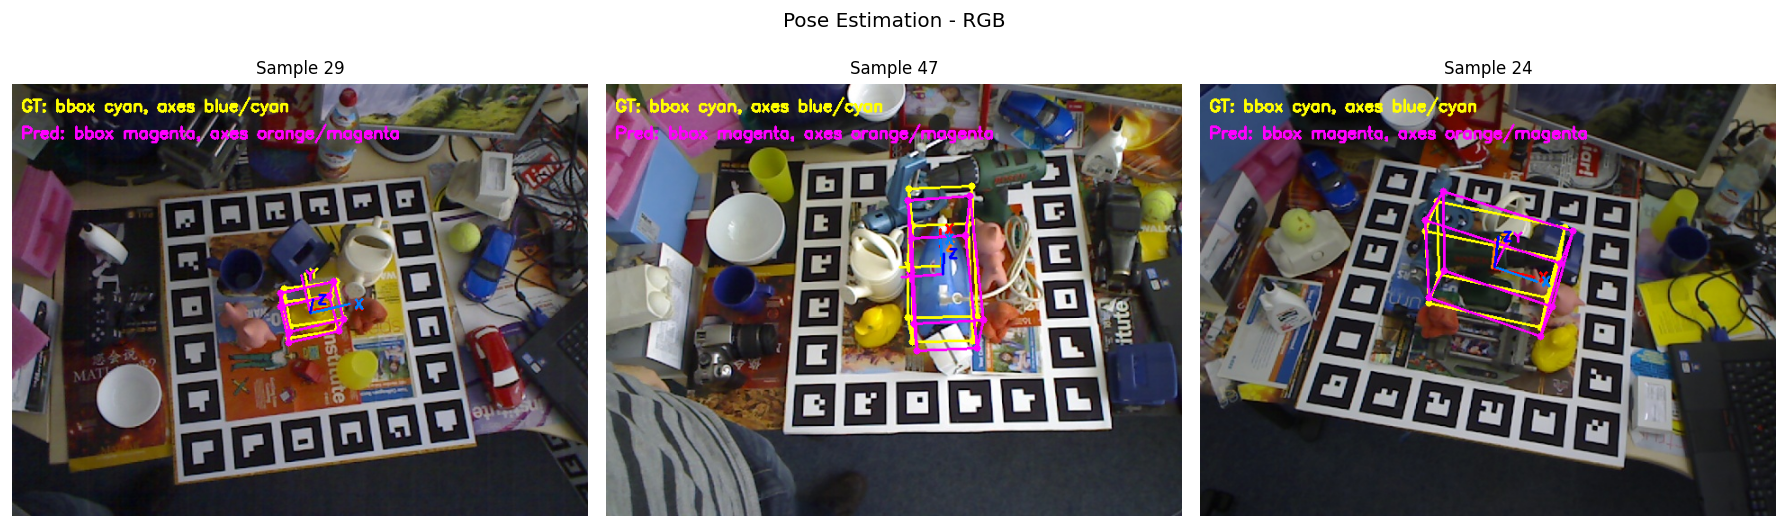

In [3]:
from src.pose_rgb.visualize import visualize_RGB_random_samples
import torch

checkpoint_dir = "./RGB_run"
dataset_root = "../../Linemod_preprocessed_small"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


visualize_RGB_random_samples(
    checkpoint_dir=checkpoint_dir,
    dataset_root=dataset_root,
    device=device,
    num_samples=3
)



# Evaluation

In [2]:
import sys
sys.path.append('../..')

In [ ]:
from src.pose_rgb.evaluate import evaluate_RGB, evaluate_RGB_rot_only

model_path = "./RGB_run/best_model_rot.pth"
dataset_root = "../../Linemod_preprocessed"
output_path = "./RGB_run/evaluation_results.csv"


df = evaluate_RGB_rot_only(
    model_path=model_path,
    dataset_root=dataset_root,
    output_path=output_path
)
    
df

📥 Loading 3D model points and diameters...
📦 Loading trained model...
📚 Preparing test dataset and dataloader...
 Loaded LineModPoseDepthDataset
   Split: test (Ratio: 0.20)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 4867

🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating: 100%|██████████| 39/39 [16:03<00:00, 24.70s/batch]


📊 Evaluation report saved to ./RGB_run/evaluation_results.csv


,Object ID,Object Name,Diameter (mm),Mean ADD (mm),Mean ADD-S (mm),Mean ADD-Rot (mm),Mean ADD-S-Rot (mm),ADD-0.1d Accuracy (%),ADD-S-0.1d Accuracy (%)
0,1,ape,102.098657,6.371118,2.129254,6.371118,2.129254,86.864407,99.788136
1,2,benchvise,247.506242,12.728971,5.129825,12.728971,5.129825,92.148760,100.000000
2,5,can,201.403586,10.640517,3.693451,10.640517,3.693451,93.920335,99.790356
3,6,cat,154.545518,7.686827,3.226671,7.686827,3.226671,92.374728,99.128540
4,8,driller,261.471781,11.043530,5.103864,11.043530,5.103864,96.210526,100.000000
5,9,duck,108.999201,8.140133,2.754954,8.140133,2.754954,83.609959,99.792531
6,10,eggbox,164.627588,10.934605,3.253344,10.934605,3.253344,87.731481,100.000000
7,11,glue,175.889334,8.390186,3.777869,8.390186,3.777869,95.161290,100.000000
8,12,holepuncher,145.542875,9.141986,2.895303,9.141986,2.895303,85.918367,100.000000
9,4,camera,172.492249,8.409860,3.107158,8.409860,3.107158,95.020747,100.000000


In [2]:
from src.pose_rgb.evaluate import evaluate_RGB

rot_model_path = "./RGB_run/best_model_rot.pth"
trans_model_path = "./RGB_run/best_model_trans.pth"
dataset_root = "../../Linemod_preprocessed"
output_path = "./RGB_run/evaluation_results.csv"

df = evaluate_RGB(
    rot_model_path=rot_model_path,
    trans_model_path=trans_model_path,
    dataset_root=dataset_root,
    output_path=output_path
)

df

✅ LineModConfig initialized: F:\Magistrale\Advanced Machine Learning\6D_pose\Linemod_preprocessed
📥 Loading 3D model points and diameters...
📦 Loading trained model...
📚 Preparing test dataset and dataloader...
 Loaded LineModPoseDataset
   Split: test (Ratio: 0.20)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3163

🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating: 100%|██████████| 25/25 [10:59<00:00, 26.39s/batch]


📊 Evaluation report saved to ./RGB_run/evaluation_results.csv


,Object ID,Object Name,Diameter (mm),Mean ADD (mm),Mean ADD-S (mm),Mean ADD-Rot (mm),Mean ADD-S-Rot (mm),ADD-0.1d Accuracy (%),ADD-S-0.1d Accuracy (%)
0,1,ape,102.098657,6.085767,2.071537,6.087063,2.072475,89.919355,99.596774
1,2,benchvise,247.506242,12.725919,5.127696,12.728971,5.129825,92.148760,100.000000
2,4,camera,172.492249,8.410535,3.107828,8.409860,3.107158,95.020747,100.000000
3,5,can,201.403586,10.067678,3.583363,10.067564,3.583570,94.166667,100.000000
4,6,cat,154.545518,6.356540,2.745854,6.357031,2.745473,97.033898,100.000000
5,8,driller,261.471781,10.847204,4.974985,10.846855,4.974903,96.638655,100.000000
6,9,duck,108.999201,6.848255,2.582741,6.848790,2.583005,90.438247,99.601594
7,10,eggbox,164.627588,10.666777,3.205979,10.666377,3.205639,87.649402,100.000000
8,11,glue,175.889334,7.972006,3.530785,7.973717,3.532350,95.473251,100.000000
9,12,holepuncher,145.542875,7.397596,2.609783,7.397316,2.609874,93.951613,100.000000


# Full pipeline eval

In [2]:
import sys

sys.path.append('../..')

In [4]:
from src.pose_rgb.evaluate import evaluate_RGB

rot_model_path = "./RGB_run/best_model_rot.pth"
trans_model_path = "./RGB_run/best_model_trans.pth"
dataset_root = "../../Linemod_preprocessed"
output_path = "./RGB_run/evaluation_results.csv"
yolo_path = "../../YOLO_outputs"

df = evaluate_RGB(
    rot_model_path=rot_model_path,
    trans_model_path=trans_model_path,
    dataset_root=dataset_root,
    output_path=output_path,
    yolo_path=yolo_path
)

df

📥 Loading 3D model points and diameters...
📦 Loading trained model...
📚 Preparing test dataset and dataloader...

🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating: 100%|██████████| 25/25 [10:59<00:00, 26.37s/batch]


📊 Evaluation report saved to ./RGB_run/evaluation_results.csv


,Object ID,Object Name,Diameter (mm),Mean ADD (mm),Mean ADD-S (mm),Mean ADD-Rot (mm),Mean ADD-S-Rot (mm),ADD-0.1d Accuracy (%),ADD-S-0.1d Accuracy (%)
0,1,ape,102.098657,6.052712,2.093204,6.054070,2.094217,91.532258,100.000000
1,2,benchvise,247.506242,14.971043,5.706105,14.973602,5.707725,88.477366,99.588477
2,4,camera,172.492249,8.211592,3.095681,8.210999,3.094995,95.435685,100.000000
3,5,can,201.403586,9.510711,3.421541,9.511127,3.422004,94.166667,100.000000
4,6,cat,154.545518,6.680639,2.853596,6.681140,2.853445,96.610169,100.000000
5,8,driller,261.471781,10.681136,4.988603,10.681449,4.988824,97.478992,100.000000
6,9,duck,108.999201,7.139426,2.672690,7.140201,2.673066,87.649402,100.000000
7,10,eggbox,164.627588,10.825070,3.191536,10.824610,3.191210,89.243028,100.000000
8,11,glue,175.889334,8.217083,3.623616,8.219139,3.625635,94.262295,100.000000
9,12,holepuncher,145.542875,7.927411,2.770206,7.926609,2.770206,92.338710,100.000000
